# 12 - SIFT + SfM Relative Pair Pose


## Ziel
Dieses Notebook testet **zwei Bilder relativ zueinander** mit:

- SIFT Keypoints + Descriptor Matching
- 2D Bewegungsschaetzung (Affine: Rotation, Translation, Scale)
- SfM-Relativpose (Essential Matrix: `R`, `t`-Richtung)
- Visualisierung in 2 Spalten pro Variante (a/b/c), aehnlich deinem Beispiel

Die Paar-IDs (`PAIR_ANCHOR_ID`, `PAIR_VAL_ID`) und Matching-Varianten sind direkt unten einstellbar.


In [15]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


In [16]:
# Basic checks + paths
if not hasattr(cv2, 'SIFT_create'):
    raise RuntimeError('OpenCV build has no SIFT. Please install opencv-contrib-python.')

CANDIDATE_ROOTS = [Path.cwd(), Path.cwd().parent, Path('.'), Path('..')]
PROJECT_ROOT = None
_seen = set()
for cand in CANDIDATE_ROOTS:
    try:
        root = cand.resolve()
    except Exception:
        continue
    k = str(root)
    if k in _seen:
        continue
    _seen.add(k)
    if (root / 'data' / 'data').exists():
        PROJECT_ROOT = root
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError('Could not find project root containing data/data.')

DATA_ROOT = PROJECT_ROOT / 'data' / 'data'
TRAIN_IMG_DIR = DATA_ROOT / 'train_data' / 'train_images'
TRAIN_POS_CSV = DATA_ROOT / 'train_data' / 'train_pos.csv'
TRAIN_CAM_CSV = DATA_ROOT / 'train_data' / 'train_cam.csv'

# Pair selection
PAIR_ANCHOR_ID = 2568
PAIR_VAL_ID = 2569
PREVIEW_PAIR_INDEX = 0

# Runtime + preprocessing
IMAGE_MAX_SIDE = 1400  # None for full resolution
PREPROCESS_MODE = 'gray_clahe'  # ['gray', 'gray_clahe', 'gray_denoise_clahe']

# Geometry thresholds
AFFINE_RANSAC_THR = 3.0
HOMOGRAPHY_RANSAC_THR = 4.0
ESSENTIAL_RANSAC_THR = 1.5

# Draw control
MAX_DRAW_MATCHES = 500

print('project_root:', PROJECT_ROOT)


project_root: /home/dev/workspace/gnss-denied-localization


In [17]:
# Load train table + consecutive pairs
train_pos_df = pd.read_csv(TRAIN_POS_CSV)
train_cam_df = pd.read_csv(TRAIN_CAM_CSV)
train_df = train_cam_df.merge(train_pos_df, on='id', how='inner').copy()
train_df['id'] = train_df['id'].astype(int)
train_df = train_df.sort_values('id').reset_index(drop=True)

required_cols = ['id', 'x_pixel', 'y_pixel', 'fx', 'fy', 'cx', 'cy']
for c in required_cols:
    if c not in train_df.columns:
        raise KeyError(f'Missing required column: {c}')

pairs = []
for i in range(len(train_df) - 1):
    r0 = train_df.iloc[i]
    r1 = train_df.iloc[i + 1]
    id0 = int(r0['id'])
    id1 = int(r1['id'])
    if id1 != id0 + 1:
        continue
    pairs.append({
        'pair_idx': len(pairs),
        'anchor_id': id0,
        'val_id': id1,
    })
pair_df = pd.DataFrame(pairs)

print('consecutive pairs:', len(pair_df))
display(pair_df.head(20))


consecutive pairs: 296


pair_idx  anchor_id  val_id
0          0         13      14
1          1         14      15
2          2         15      16
3          3         16      17
4          4         17      18
5          5         18      19
6          6         19      20
7          7         20      21
8          8         21      22
9          9         22      23
10        10         23      24
11        11         24      25
12        12         25      26
13        13         26      27
14        14         27      28
15        15         28      29
16        16         29      30
17        17         30      31
18        18         31      32
19        19         32      33

In [18]:
# Utilities: image loading, preprocess, intrinsics
_IMAGE_CACHE: Dict[Tuple[int, Optional[int]], Tuple[np.ndarray, float]] = {}


def resolve_train_image_path(image_id: int) -> Path:
    stems = [f'{int(image_id):04d}', str(int(image_id))]
    exts = ['.JPG', '.jpg', '.jpeg', '.JPEG', '.png', '.PNG']
    for st in stems:
        for ext in exts:
            p = TRAIN_IMG_DIR / f'{st}{ext}'
            if p.exists():
                return p
    raise FileNotFoundError(f'Image not found for id={image_id} in {TRAIN_IMG_DIR}')


def load_train_image_cached(image_id: int, max_side: Optional[int]) -> Tuple[np.ndarray, float]:
    key = (int(image_id), max_side)
    if key in _IMAGE_CACHE:
        return _IMAGE_CACHE[key]

    p = resolve_train_image_path(int(image_id))
    bgr = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if bgr is None:
        raise RuntimeError(f'Cannot read image: {p}')
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    scale = 1.0
    if max_side is not None:
        h, w = rgb.shape[:2]
        m = max(h, w)
        if m > int(max_side):
            scale = float(max_side) / float(m)
            nw = max(32, int(round(w * scale)))
            nh = max(32, int(round(h * scale)))
            rgb = cv2.resize(rgb, (nw, nh), interpolation=cv2.INTER_AREA)

    _IMAGE_CACHE[key] = (rgb, scale)
    return rgb, scale


def preprocess_for_sift(img_rgb: np.ndarray, mode: str = 'gray_clahe') -> np.ndarray:
    g = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    if mode == 'gray':
        return g
    if mode == 'gray_clahe':
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
        return clahe.apply(g)
    if mode == 'gray_denoise_clahe':
        g2 = cv2.bilateralFilter(g, d=7, sigmaColor=45, sigmaSpace=45)
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
        return clahe.apply(g2)
    raise KeyError(f'Unknown preprocess mode: {mode}')


def scaled_K(cam_row: pd.Series, image_scale: float) -> np.ndarray:
    fx = float(cam_row['fx']) * float(image_scale)
    fy = float(cam_row['fy']) * float(image_scale)
    cx = float(cam_row['cx']) * float(image_scale)
    cy = float(cam_row['cy']) * float(image_scale)
    return np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]], dtype=np.float64)


def select_pair_row(pair_df: pd.DataFrame, anchor_id: int, val_id: int, fallback_idx: int = 0) -> pd.Series:
    sel = pair_df[
        (pair_df['anchor_id'].astype(int) == int(anchor_id)) &
        (pair_df['val_id'].astype(int) == int(val_id))
    ]
    if len(sel) > 0:
        return sel.iloc[0]
    idx = int(np.clip(fallback_idx, 0, len(pair_df) - 1))
    print(f'Pair {anchor_id}->{val_id} not found, fallback index {idx}.')
    return pair_df.iloc[idx]


pair: 2568->2569
img0: (1049, 1400, 3) scale0: 0.1748
img1: (1049, 1400, 3) scale1: 0.1748


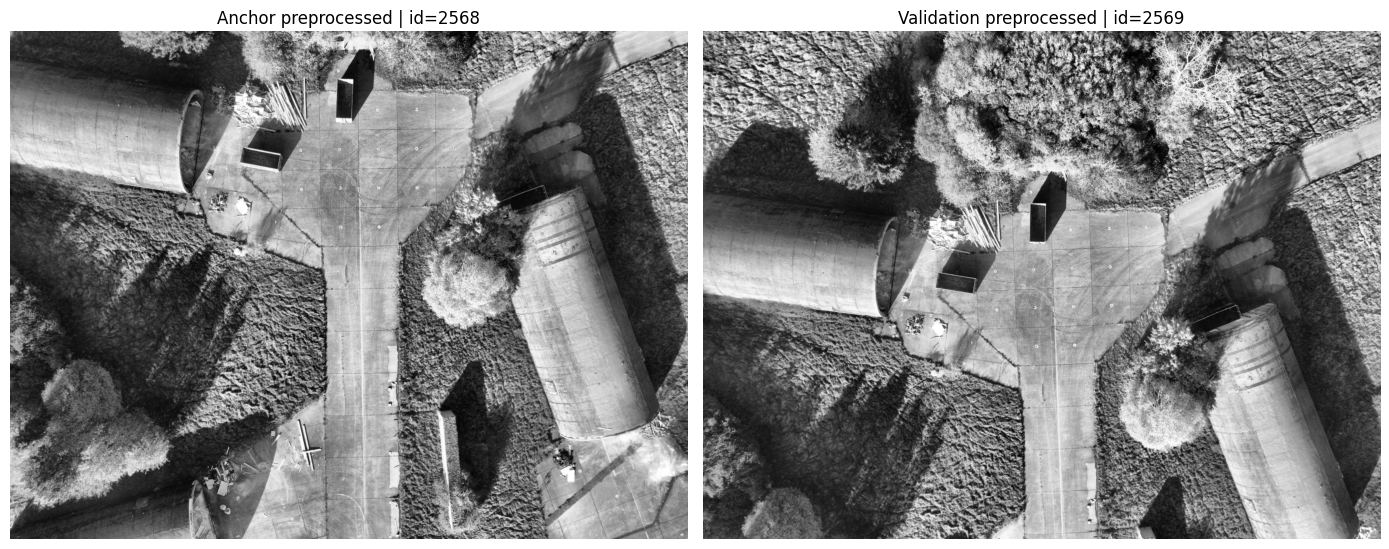

In [19]:
# Pair data preparation
pair_row = select_pair_row(pair_df, PAIR_ANCHOR_ID, PAIR_VAL_ID, PREVIEW_PAIR_INDEX)
anchor_id = int(pair_row['anchor_id'])
val_id = int(pair_row['val_id'])

r0 = train_df[train_df['id'].astype(int) == anchor_id].iloc[0]
r1 = train_df[train_df['id'].astype(int) == val_id].iloc[0]

img0_rgb, scale0 = load_train_image_cached(anchor_id, max_side=IMAGE_MAX_SIDE)
img1_rgb, scale1 = load_train_image_cached(val_id, max_side=IMAGE_MAX_SIDE)

gray0 = preprocess_for_sift(img0_rgb, mode=PREPROCESS_MODE)
gray1 = preprocess_for_sift(img1_rgb, mode=PREPROCESS_MODE)

K0 = scaled_K(r0, scale0)
K1 = scaled_K(r1, scale1)

print(f'pair: {anchor_id}->{val_id}')
print('img0:', img0_rgb.shape, 'scale0:', round(scale0, 4))
print('img1:', img1_rgb.shape, 'scale1:', round(scale1, 4))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(gray0, cmap='gray')
axes[0].set_title(f'Anchor preprocessed | id={anchor_id}')
axes[0].axis('off')
axes[1].imshow(gray1, cmap='gray')
axes[1].set_title(f'Validation preprocessed | id={val_id}')
axes[1].axis('off')
plt.tight_layout()
plt.show()


In [20]:
# SIFT matching + geometry (Affine/Homography + SfM)
@dataclass
class PairMatchResult:
    name: str
    keypoints0: List[cv2.KeyPoint]
    keypoints1: List[cv2.KeyPoint]
    matches: List[cv2.DMatch]
    pts0: np.ndarray
    pts1: np.ndarray
    kp_size0: np.ndarray
    kp_size1: np.ndarray
    affine_M_1to0: Optional[np.ndarray]
    affine_inliers: np.ndarray
    affine_rotation_deg: float
    affine_tx: float
    affine_ty: float
    affine_scale: float
    affine_rmse: float
    H_1to0: Optional[np.ndarray]
    homography_inliers: np.ndarray
    sfm_R: Optional[np.ndarray]
    sfm_t: Optional[np.ndarray]
    sfm_inliers: np.ndarray
    sfm_rot_deg: float
    sfm_yaw_deg: float
    sfm_pitch_deg: float
    sfm_roll_deg: float


def rotation_matrix_to_euler_zyx(R: np.ndarray) -> Tuple[float, float, float]:
    sy = float(np.sqrt(R[0, 0] ** 2 + R[1, 0] ** 2))
    singular = sy < 1e-6

    if not singular:
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = np.arctan2(-R[2, 0], sy)
        roll = np.arctan2(R[2, 1], R[2, 2])
    else:
        yaw = np.arctan2(-R[0, 1], R[1, 1])
        pitch = np.arctan2(-R[2, 0], sy)
        roll = 0.0

    return float(np.degrees(yaw)), float(np.degrees(pitch)), float(np.degrees(roll))


def affine_transform_points(M: np.ndarray, pts: np.ndarray) -> np.ndarray:
    if pts.shape[0] == 0:
        return pts.copy()
    ones = np.ones((pts.shape[0], 1), dtype=np.float32)
    p = np.hstack([pts.astype(np.float32), ones])
    q = (M @ p.T).T
    return q.astype(np.float32)


def run_sift_sfm_variant(
    gray0: np.ndarray,
    gray1: np.ndarray,
    K0: np.ndarray,
    K1: np.ndarray,
    name: str,
    nfeatures: int,
    contrast_thr: float,
    edge_thr: float,
    sigma: float,
    ratio_thr: float,
    affine_thr: float,
    homography_thr: float,
    essential_thr: float,
) -> PairMatchResult:
    sift = cv2.SIFT_create(
        nfeatures=int(nfeatures),
        contrastThreshold=float(contrast_thr),
        edgeThreshold=float(edge_thr),
        sigma=float(sigma),
    )

    k0, d0 = sift.detectAndCompute(gray0, None)
    k1, d1 = sift.detectAndCompute(gray1, None)

    if d0 is None or d1 is None or len(k0) == 0 or len(k1) == 0:
        return PairMatchResult(
            name=name,
            keypoints0=k0 if k0 is not None else [],
            keypoints1=k1 if k1 is not None else [],
            matches=[],
            pts0=np.zeros((0, 2), np.float32),
            pts1=np.zeros((0, 2), np.float32),
            kp_size0=np.zeros((0,), np.float32),
            kp_size1=np.zeros((0,), np.float32),
            affine_M_1to0=None,
            affine_inliers=np.zeros((0,), bool),
            affine_rotation_deg=np.nan,
            affine_tx=np.nan,
            affine_ty=np.nan,
            affine_scale=np.nan,
            affine_rmse=np.nan,
            H_1to0=None,
            homography_inliers=np.zeros((0,), bool),
            sfm_R=None,
            sfm_t=None,
            sfm_inliers=np.zeros((0,), bool),
            sfm_rot_deg=np.nan,
            sfm_yaw_deg=np.nan,
            sfm_pitch_deg=np.nan,
            sfm_roll_deg=np.nan,
        )

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    knn = bf.knnMatch(d0, d1, k=2)

    good = []
    for pair in knn:
        if len(pair) < 2:
            continue
        m, n = pair
        if m.distance < float(ratio_thr) * n.distance:
            good.append(m)

    if len(good) == 0:
        return PairMatchResult(
            name=name,
            keypoints0=k0,
            keypoints1=k1,
            matches=[],
            pts0=np.zeros((0, 2), np.float32),
            pts1=np.zeros((0, 2), np.float32),
            kp_size0=np.zeros((0,), np.float32),
            kp_size1=np.zeros((0,), np.float32),
            affine_M_1to0=None,
            affine_inliers=np.zeros((0,), bool),
            affine_rotation_deg=np.nan,
            affine_tx=np.nan,
            affine_ty=np.nan,
            affine_scale=np.nan,
            affine_rmse=np.nan,
            H_1to0=None,
            homography_inliers=np.zeros((0,), bool),
            sfm_R=None,
            sfm_t=None,
            sfm_inliers=np.zeros((0,), bool),
            sfm_rot_deg=np.nan,
            sfm_yaw_deg=np.nan,
            sfm_pitch_deg=np.nan,
            sfm_roll_deg=np.nan,
        )

    pts0 = np.array([k0[m.queryIdx].pt for m in good], dtype=np.float32)
    pts1 = np.array([k1[m.trainIdx].pt for m in good], dtype=np.float32)
    s0 = np.array([k0[m.queryIdx].size for m in good], dtype=np.float32)
    s1 = np.array([k1[m.trainIdx].size for m in good], dtype=np.float32)

    # Affine 1->0 (for pixel rotation/translation/scale)
    if len(good) >= 3:
        M, inl_aff = cv2.estimateAffinePartial2D(
            pts1,
            pts0,
            method=cv2.RANSAC,
            ransacReprojThreshold=float(affine_thr),
            maxIters=20000,
            confidence=0.999,
            refineIters=50,
        )
    else:
        M, inl_aff = None, None

    if M is not None and inl_aff is not None:
        inl_aff = inl_aff.ravel().astype(bool)
        rot_deg = float(np.degrees(np.arctan2(M[1, 0], M[0, 0])))
        scale = float(np.sqrt(M[0, 0] ** 2 + M[1, 0] ** 2))
        tx = float(M[0, 2])
        ty = float(M[1, 2])

        p1w = affine_transform_points(M, pts1)
        if np.any(inl_aff):
            err = np.linalg.norm(pts0[inl_aff] - p1w[inl_aff], axis=1)
            rmse = float(np.sqrt(np.mean(err ** 2)))
        else:
            rmse = np.nan
    else:
        inl_aff = np.zeros((len(good),), dtype=bool)
        rot_deg = np.nan
        scale = np.nan
        tx = np.nan
        ty = np.nan
        rmse = np.nan

    # Homography 1->0 (optional, diagnostics)
    if len(good) >= 4:
        H, inl_h = cv2.findHomography(
            pts1,
            pts0,
            method=cv2.USAC_MAGSAC,
            ransacReprojThreshold=float(homography_thr),
            maxIters=20000,
            confidence=0.999,
        )
    else:
        H, inl_h = None, None

    if H is not None and inl_h is not None:
        inl_h = inl_h.ravel().astype(bool)
    else:
        H = None
        inl_h = np.zeros((len(good),), dtype=bool)

    # SfM relative pose from normalized points
    sfm_R = None
    sfm_t = None
    sfm_inl = np.zeros((len(good),), dtype=bool)
    sfm_rot = np.nan
    sfm_yaw = np.nan
    sfm_pitch = np.nan
    sfm_roll = np.nan

    if len(good) >= 8:
        pts0n = cv2.undistortPoints(pts0.reshape(-1, 1, 2), K0, None).reshape(-1, 2)
        pts1n = cv2.undistortPoints(pts1.reshape(-1, 1, 2), K1, None).reshape(-1, 2)

        E, inl_e = cv2.findEssentialMat(
            pts0n,
            pts1n,
            cameraMatrix=np.eye(3),
            method=cv2.RANSAC,
            prob=0.999,
            threshold=float(essential_thr),
        )

        if E is not None and inl_e is not None:
            inl_e = inl_e.ravel().astype(bool)
            if np.count_nonzero(inl_e) >= 8:
                _, R, t, inl_pose = cv2.recoverPose(
                    E,
                    pts0n,
                    pts1n,
                    cameraMatrix=np.eye(3),
                    mask=inl_e.astype(np.uint8).reshape(-1, 1),
                )
                sfm_R = R
                sfm_t = t.reshape(3)
                if inl_pose is not None:
                    sfm_inl = inl_pose.ravel().astype(bool)
                else:
                    sfm_inl = inl_e.copy()

                rvec, _ = cv2.Rodrigues(R)
                sfm_rot = float(np.linalg.norm(rvec) * 180.0 / np.pi)
                sfm_yaw, sfm_pitch, sfm_roll = rotation_matrix_to_euler_zyx(R)

    return PairMatchResult(
        name=name,
        keypoints0=k0,
        keypoints1=k1,
        matches=good,
        pts0=pts0,
        pts1=pts1,
        kp_size0=s0,
        kp_size1=s1,
        affine_M_1to0=M,
        affine_inliers=inl_aff,
        affine_rotation_deg=rot_deg,
        affine_tx=tx,
        affine_ty=ty,
        affine_scale=scale,
        affine_rmse=rmse,
        H_1to0=H,
        homography_inliers=inl_h,
        sfm_R=sfm_R,
        sfm_t=sfm_t,
        sfm_inliers=sfm_inl,
        sfm_rot_deg=sfm_rot,
        sfm_yaw_deg=sfm_yaw,
        sfm_pitch_deg=sfm_pitch,
        sfm_roll_deg=sfm_roll,
    )


In [21]:
# Variant grid (a/b/c) and run
VARIANTS = [
    {
        'name': 'a_strict',
        'nfeatures': 6000,
        'contrast_thr': 0.04,
        'edge_thr': 10,
        'sigma': 1.6,
        'ratio_thr': 0.70,
    },
    {
        'name': 'b_balanced',
        'nfeatures': 9000,
        'contrast_thr': 0.03,
        'edge_thr': 12,
        'sigma': 1.6,
        'ratio_thr': 0.78,
    },
    {
        'name': 'c_loose',
        'nfeatures': 12000,
        'contrast_thr': 0.02,
        'edge_thr': 14,
        'sigma': 1.6,
        'ratio_thr': 0.86,
    },
]

results: List[PairMatchResult] = []
for v in VARIANTS:
    out = run_sift_sfm_variant(
        gray0=gray0,
        gray1=gray1,
        K0=K0,
        K1=K1,
        name=v['name'],
        nfeatures=v['nfeatures'],
        contrast_thr=v['contrast_thr'],
        edge_thr=v['edge_thr'],
        sigma=v['sigma'],
        ratio_thr=v['ratio_thr'],
        affine_thr=AFFINE_RANSAC_THR,
        homography_thr=HOMOGRAPHY_RANSAC_THR,
        essential_thr=ESSENTIAL_RANSAC_THR,
    )
    results.append(out)

print('Finished variants:', [r.name for r in results])


Finished variants: ['a_strict', 'b_balanced', 'c_loose']


In [22]:
# Visualization helpers

def to_rgb(gray: np.ndarray) -> np.ndarray:
    if gray.ndim == 2:
        return cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    return gray.copy()


def clip_pt(p: np.ndarray, w: int, h: int) -> Tuple[int, int]:
    x = int(np.clip(round(float(p[0])), 0, w - 1))
    y = int(np.clip(round(float(p[1])), 0, h - 1))
    return x, y


def draw_variant_pair(
    gray0: np.ndarray,
    gray1: np.ndarray,
    res: PairMatchResult,
    max_draw: int = 500,
) -> Tuple[np.ndarray, np.ndarray]:
    h0, w0 = gray0.shape[:2]

    left = to_rgb(gray0)

    if res.affine_M_1to0 is not None:
        warped1 = cv2.warpAffine(gray1, res.affine_M_1to0, (w0, h0), flags=cv2.INTER_LINEAR, borderValue=0)
        p1w = affine_transform_points(res.affine_M_1to0, res.pts1)
    else:
        warped1 = cv2.resize(gray1, (w0, h0), interpolation=cv2.INTER_LINEAR)
        p1w = np.zeros_like(res.pts1)

    right = cv2.addWeighted(to_rgb(gray0), 0.45, to_rgb(warped1), 0.55, 0.0)

    n = len(res.matches)
    if n == 0:
        return left, right

    draw_idx = np.arange(n, dtype=np.int32)
    inl = res.affine_inliers if res.affine_inliers.shape[0] == n else np.zeros((n,), dtype=bool)

    # prioritize inliers
    if draw_idx.size > max_draw:
        inl_idx = np.where(inl)[0]
        out_idx = np.where(~inl)[0]
        if inl_idx.size >= max_draw:
            draw_idx = inl_idx[:max_draw]
        else:
            rem = max_draw - inl_idx.size
            draw_idx = np.concatenate([inl_idx, out_idx[:rem]])

    for i in draw_idx:
        ok = bool(inl[i])
        col = (0, 255, 0) if ok else (255, 0, 0)

        p0 = res.pts0[i]
        x0, y0 = clip_pt(p0, w0, h0)
        r0 = int(max(2, round(float(res.kp_size0[i]) * 0.35)))
        cv2.circle(left, (x0, y0), r0, col, 1, cv2.LINE_AA)
        cv2.circle(left, (x0, y0), 1, (255, 255, 0), -1, cv2.LINE_AA)

        if res.affine_M_1to0 is not None:
            p1 = p1w[i]
            x1, y1 = clip_pt(p1, w0, h0)
            r1 = int(max(2, round(float(res.kp_size1[i]) * 0.35)))
            cv2.circle(right, (x1, y1), r1, col, 1, cv2.LINE_AA)
            cv2.circle(right, (x1, y1), 1, (255, 255, 0), -1, cv2.LINE_AA)

            # residual line in anchor frame (for inliers only)
            if ok:
                cv2.line(left, (x0, y0), (x1, y1), (0, 255, 255), 1, cv2.LINE_AA)

    return left, right


def summarize_result(res: PairMatchResult) -> Dict[str, object]:
    sfm_tx, sfm_ty, sfm_tz = (np.nan, np.nan, np.nan)
    if res.sfm_t is not None:
        t = res.sfm_t.astype(float)
        n = float(np.linalg.norm(t))
        if n > 1e-12:
            t = t / n
        sfm_tx, sfm_ty, sfm_tz = float(t[0]), float(t[1]), float(t[2])

    return {
        'variant': res.name,
        'kp0': len(res.keypoints0),
        'kp1': len(res.keypoints1),
        'matches_ratio': len(res.matches),
        'affine_inliers': int(res.affine_inliers.sum()) if res.affine_inliers.size else 0,
        'homography_inliers': int(res.homography_inliers.sum()) if res.homography_inliers.size else 0,
        'affine_rot_deg': res.affine_rotation_deg,
        'affine_tx_px': res.affine_tx,
        'affine_ty_px': res.affine_ty,
        'affine_scale': res.affine_scale,
        'affine_rmse_px': res.affine_rmse,
        'sfm_inliers': int(res.sfm_inliers.sum()) if res.sfm_inliers.size else 0,
        'sfm_rot_deg': res.sfm_rot_deg,
        'sfm_yaw_deg': res.sfm_yaw_deg,
        'sfm_pitch_deg': res.sfm_pitch_deg,
        'sfm_roll_deg': res.sfm_roll_deg,
        'sfm_t_dir_x': sfm_tx,
        'sfm_t_dir_y': sfm_ty,
        'sfm_t_dir_z': sfm_tz,
    }


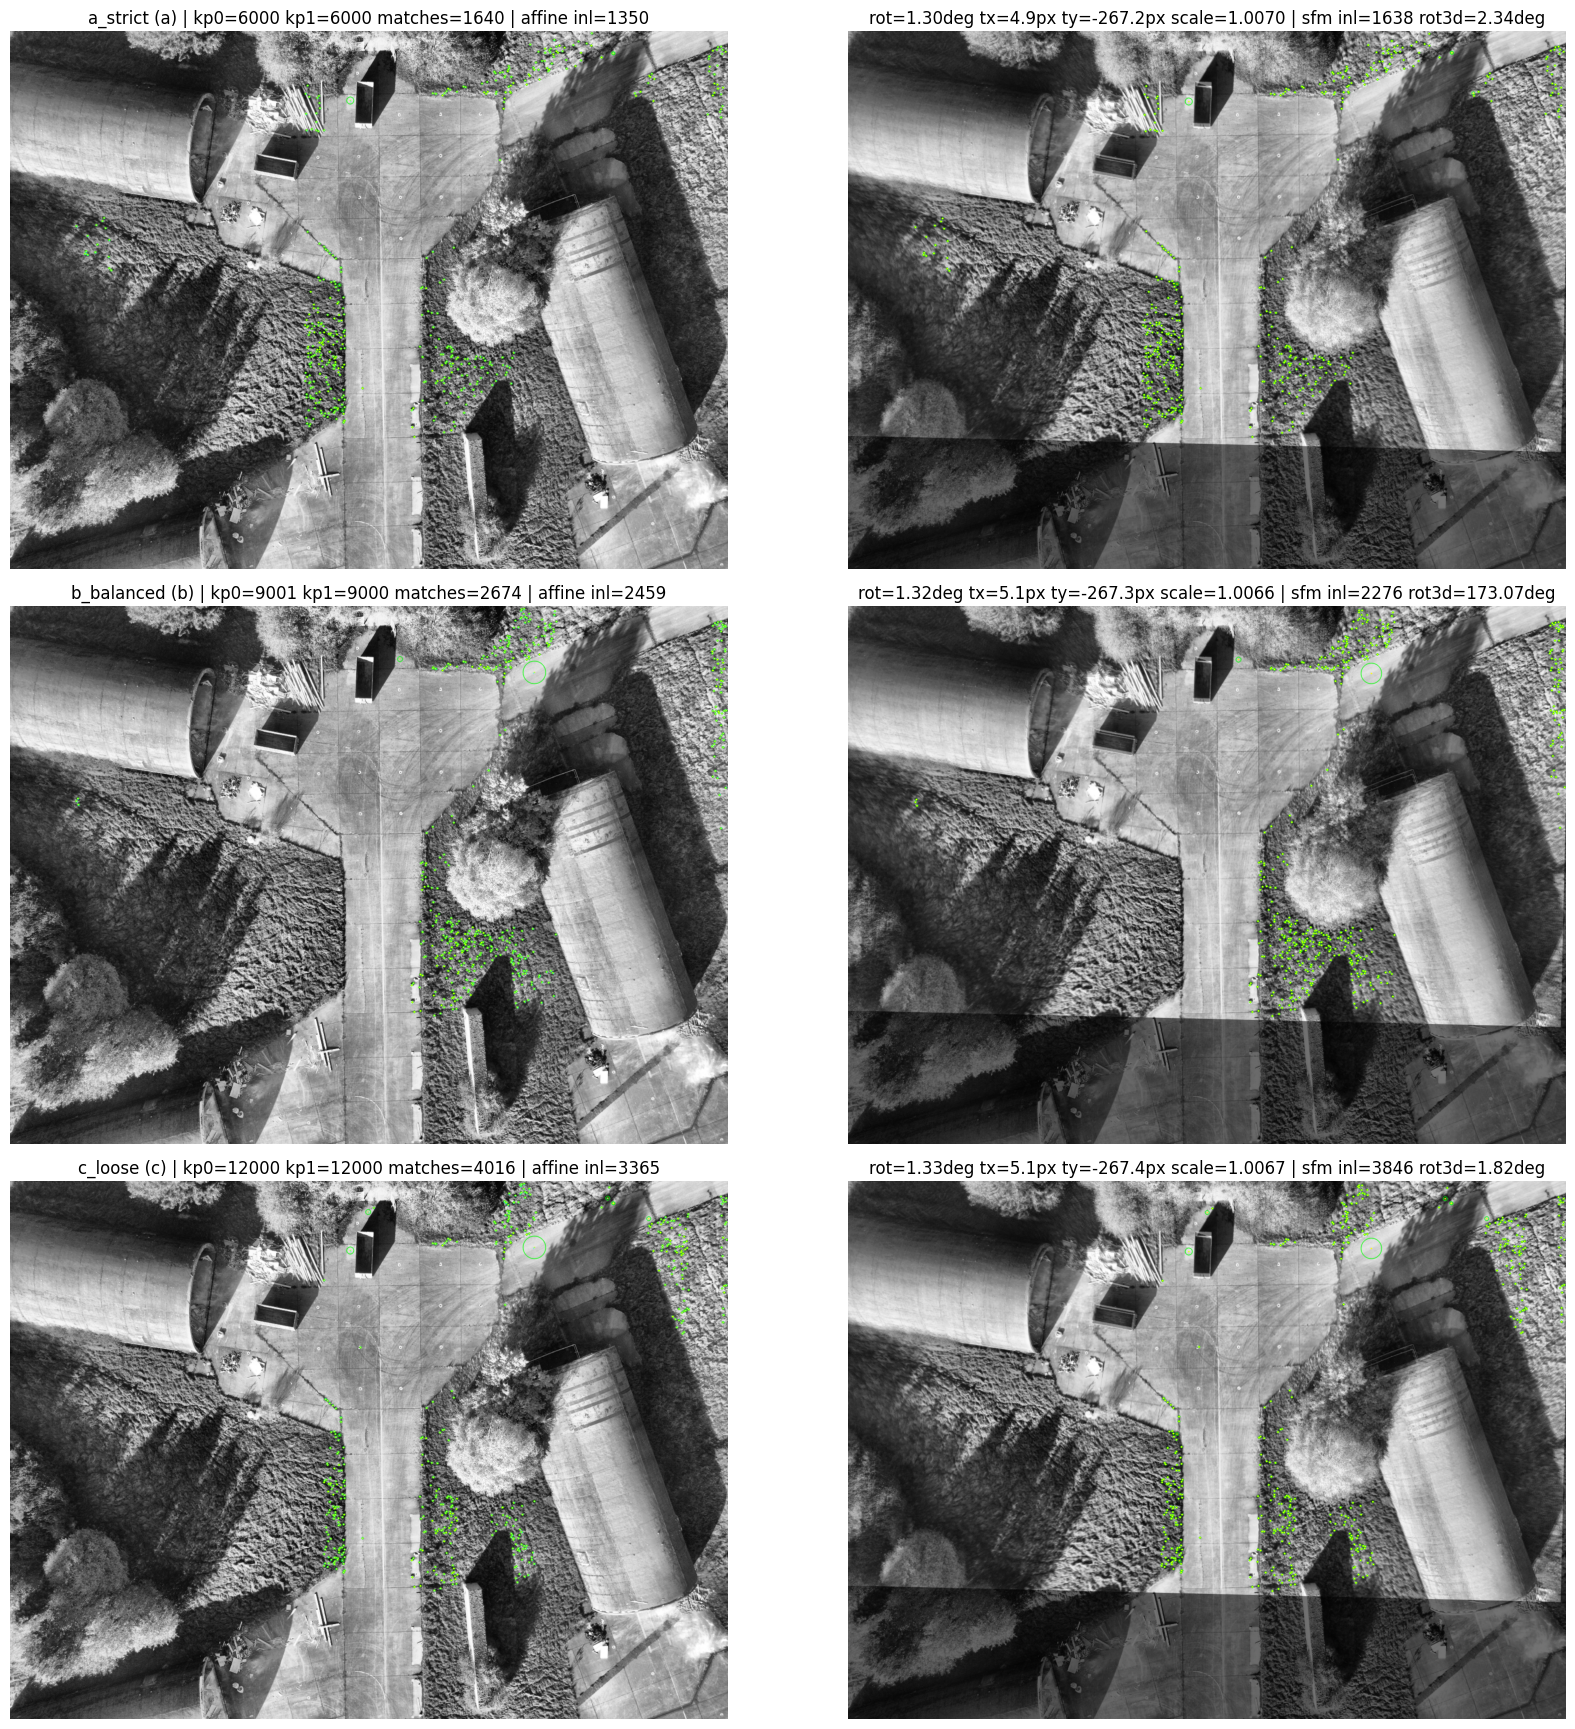

In [23]:
# Plot 2-column panel (a/b/c) similar to reference figure
if len(results) == 0:
    raise RuntimeError('No results available. Run variant cell first.')

fig, axes = plt.subplots(len(results), 2, figsize=(18, 5.8 * len(results)))
if len(results) == 1:
    axes = np.array([axes])

row_tags = ['(a)', '(b)', '(c)', '(d)', '(e)']

for r, res in enumerate(results):
    left, right = draw_variant_pair(gray0, gray1, res, max_draw=MAX_DRAW_MATCHES)

    axes[r, 0].imshow(left)
    axes[r, 0].axis('off')
    axes[r, 1].imshow(right)
    axes[r, 1].axis('off')

    tag = row_tags[r] if r < len(row_tags) else f'({r+1})'
    inl_a = int(res.affine_inliers.sum()) if res.affine_inliers.size else 0
    inl_s = int(res.sfm_inliers.sum()) if res.sfm_inliers.size else 0

    axes[r, 0].set_title(
        f"{res.name} {tag} | kp0={len(res.keypoints0)} kp1={len(res.keypoints1)} "
        f"matches={len(res.matches)} | affine inl={inl_a}"
    )
    axes[r, 1].set_title(
        f"rot={res.affine_rotation_deg:.2f}deg tx={res.affine_tx:.1f}px ty={res.affine_ty:.1f}px "
        f"scale={res.affine_scale:.4f} | sfm inl={inl_s} rot3d={res.sfm_rot_deg:.2f}deg"
    )

plt.tight_layout()
plt.show()


In [24]:
# Metrics table + best variant selection
rows = [summarize_result(r) for r in results]
metrics_df = pd.DataFrame(rows)
metrics_df = metrics_df.sort_values(['affine_inliers', 'matches_ratio'], ascending=False).reset_index(drop=True)
display(metrics_df)

best = metrics_df.iloc[0]
print('Best by affine inliers:', best['variant'])
print(
    f"2D relative pose (pixel frame): rot={best['affine_rot_deg']:.2f} deg, "
    f"tx={best['affine_tx_px']:.2f} px, ty={best['affine_ty_px']:.2f} px, scale={best['affine_scale']:.4f}"
)
print(
    f"SfM orientation approx: yaw={best['sfm_yaw_deg']:.2f}, "
    f"pitch={best['sfm_pitch_deg']:.2f}, roll={best['sfm_roll_deg']:.2f} deg"
)
print(
    f"SfM translation direction (unit): "
    f"[{best['sfm_t_dir_x']:.3f}, {best['sfm_t_dir_y']:.3f}, {best['sfm_t_dir_z']:.3f}]"
)


variant    kp0    kp1  matches_ratio  affine_inliers  \
0     c_loose  12000  12000           4016            3365   
1  b_balanced   9001   9000           2674            2459   
2    a_strict   6000   6000           1640            1350   

   homography_inliers  affine_rot_deg  affine_tx_px  affine_ty_px  \
0                3614        1.325793      5.080066   -267.406927   
1                2596        1.318295      5.127416   -267.284393   
2                1611        1.297938      4.869445   -267.248670   

   affine_scale  affine_rmse_px  sfm_inliers  sfm_rot_deg  sfm_yaw_deg  \
0      1.006666        1.179976         3846     1.821128    -1.017627   
1      1.006637        1.159604         2276   173.068785   -42.583481   
2      1.006992        0.980549         1638     2.340341    -1.247035   

   sfm_pitch_deg  sfm_roll_deg  sfm_t_dir_x  sfm_t_dir_y  sfm_t_dir_z  
0       1.080404      1.045798    -0.049854     0.998613     0.016915  
1      11.745665    167.935906     0.049125    -0.103485     0.993417  
2       0.188913     -1.973496     0.018292     0.999821    -0.004851

Best by affine inliers: c_loose
2D relative pose (pixel frame): rot=1.33 deg, tx=5.08 px, ty=-267.41 px, scale=1.0067
SfM orientation approx: yaw=-1.02, pitch=1.08, roll=1.05 deg
SfM translation direction (unit): [-0.050, 0.999, 0.017]


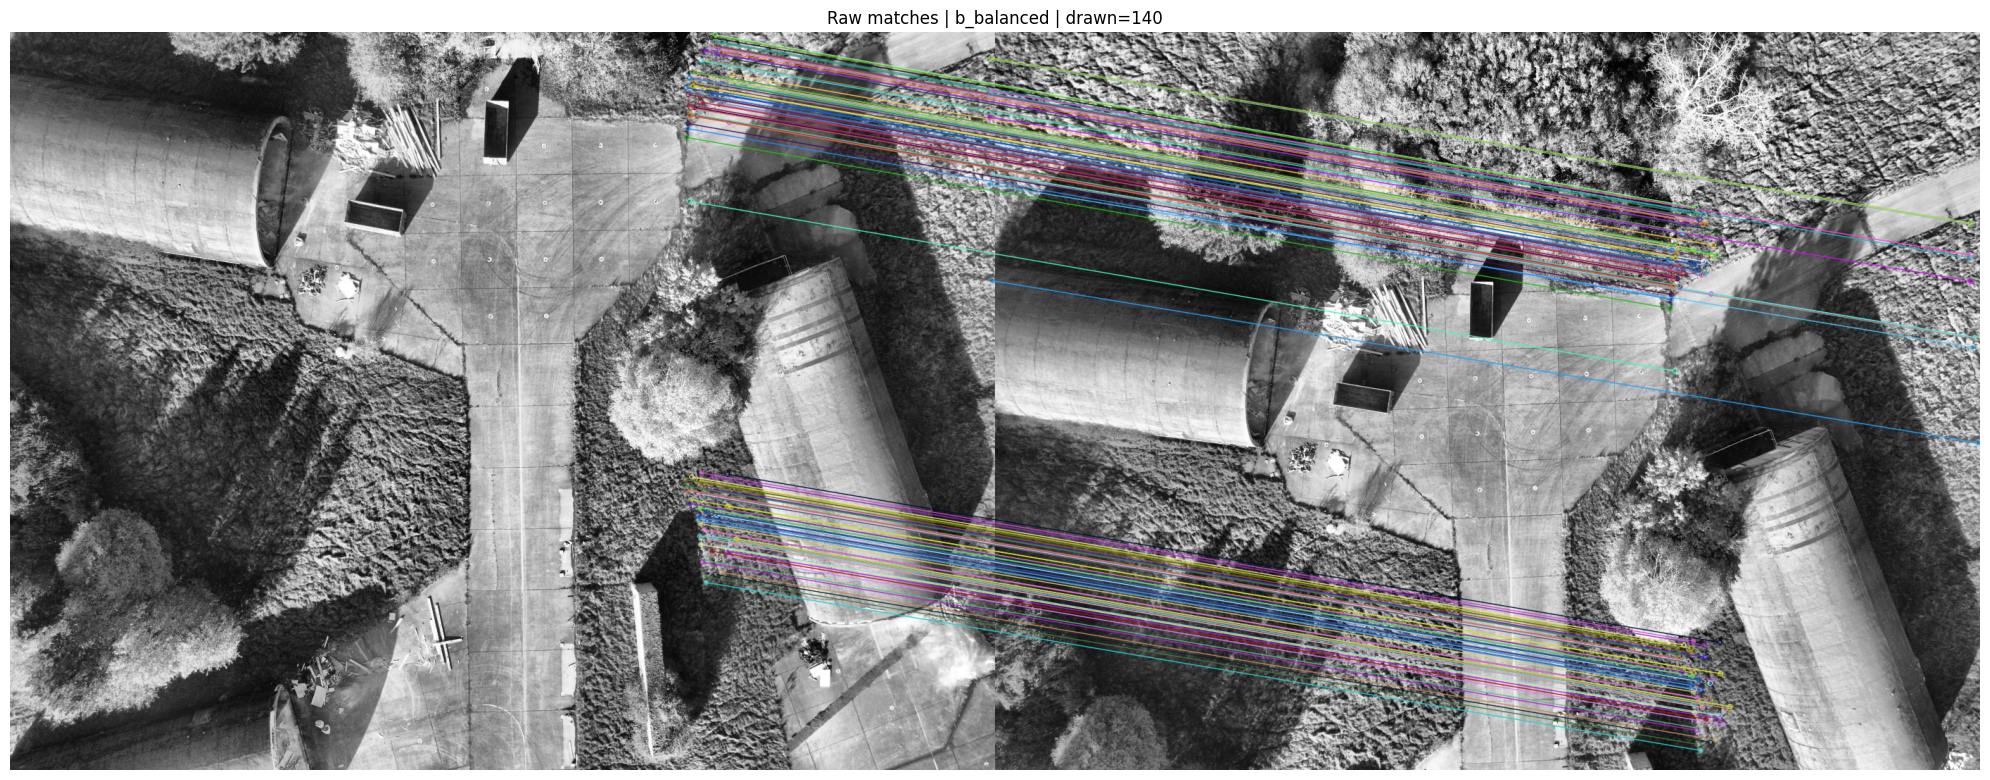

In [25]:
# Optional: visualize raw match lines for selected variant (similar to notebook 1 style)
SELECT_VARIANT = 'b_balanced'
MAX_LINE_MATCHES = 140

cand = [r for r in results if r.name == SELECT_VARIANT]
if len(cand) == 0:
    sel_res = results[0]
    print(f'Variant {SELECT_VARIANT} not found. Using {sel_res.name}.')
else:
    sel_res = cand[0]

show_idx = np.arange(len(sel_res.matches), dtype=np.int32)
inl = sel_res.affine_inliers if sel_res.affine_inliers.shape[0] == len(sel_res.matches) else np.zeros((len(sel_res.matches),), bool)
if show_idx.size > MAX_LINE_MATCHES:
    # prioritize inliers first
    inl_idx = np.where(inl)[0]
    out_idx = np.where(~inl)[0]
    need = int(MAX_LINE_MATCHES)
    if inl_idx.size >= need:
        show_idx = inl_idx[:need]
    else:
        show_idx = np.concatenate([inl_idx, out_idx[:need - inl_idx.size]])

vis0 = cv2.cvtColor(gray0, cv2.COLOR_GRAY2BGR)
vis1 = cv2.cvtColor(gray1, cv2.COLOR_GRAY2BGR)

draw_matches = [sel_res.matches[int(i)] for i in show_idx]
match_img = cv2.drawMatches(
    vis0,
    sel_res.keypoints0,
    vis1,
    sel_res.keypoints1,
    draw_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

plt.figure(figsize=(20, 8))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title(f"Raw matches | {sel_res.name} | drawn={len(draw_matches)}")
plt.axis('off')
plt.tight_layout()
plt.show()


## Anchor + 5 Sequence: global coordinates and drift diagnostics

This section builds a 6-image chain (1 anchor + 5 following images), accumulates pairwise affine transforms into the anchor frame, estimates global coordinates, and visualizes drift.


In [38]:
# Sequence config (anchor + 5 follow images)
SEQ_ANCHOR_ID =2675# anchor_id if "anchor_id" in globals() else int(PAIR_ANCHOR_ID)
SEQ_NUM_FOLLOW = 29
SEQ_VARIANT = "b_balanced"
SEQ_MIN_AFFINE_INLIERS = 120
SEQ_OVERLAY_POINT_LIMIT = 2500

def build_consecutive_sequence_ids(df: pd.DataFrame, start_id: int, num_follow: int) -> List[int]:
    id_set = set(df["id"].astype(int).tolist())
    seq = [int(start_id)]
    for _ in range(int(num_follow)):
        nxt = seq[-1] + 1
        if nxt not in id_set:
            raise ValueError(f"Missing consecutive id={nxt} for sequence from start={start_id}.")
        seq.append(nxt)
    return seq

def affine2x3_to_hom(M: np.ndarray) -> np.ndarray:
    H = np.eye(3, dtype=np.float64)
    H[:2, :] = M
    return H

def transform_points_hom(H: np.ndarray, pts: np.ndarray) -> np.ndarray:
    if pts.shape[0] == 0:
        return pts.copy()
    ones = np.ones((pts.shape[0], 1), dtype=np.float64)
    p = np.hstack([pts.astype(np.float64), ones])
    q = (H @ p.T).T
    q_xy = q[:, :2] / np.clip(q[:, 2:3], 1e-12, None)
    return q_xy.astype(np.float32)

seq_ids = build_consecutive_sequence_ids(train_df, SEQ_ANCHOR_ID, SEQ_NUM_FOLLOW)
print("sequence ids:", seq_ids)

seq_rows = train_df[train_df["id"].astype(int).isin(seq_ids)][["id", "x_pixel", "y_pixel"]].copy()
seq_rows = seq_rows.sort_values("id").reset_index(drop=True)
display(seq_rows)


sequence ids: [2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704]


id      x_pixel      y_pixel
0   2675  2721.032362  1600.984617
1   2676  2636.483514  1603.822927
2   2677  2555.707081  1606.890054
3   2678  2469.052253  1609.530215
4   2679  2384.458002  1613.747833
5   2680  2297.496806  1616.898586
6   2681  2212.745999  1621.316838
7   2682  2126.499023  1623.591467
8   2683  2045.157068  1626.191342
9   2684  1959.245280  1629.185289
10  2685  1875.240530  1631.608979
11  2686  1791.611982  1634.849423
12  2687  1705.336784  1637.622516
13  2688  1623.337660  1640.858940
14  2689  1537.963192  1644.840762
15  2690  1510.644570  1443.159781
16  2691  1602.251542  1438.741364
17  2692  1685.376310  1435.139329
18  2693  1771.791647  1432.052221
19  2694  1855.774096  1428.827346
20  2695  1936.899467  1425.980178
21  2696  2024.085092  1422.784979
22  2697  2108.809995  1419.507241
23  2698  2195.748178  1416.922992
24  2699  2280.173097  1413.722793
25  2700  2367.054614  1409.887082
26  2701  2449.581195  1407.015052
27  2702  2534.731499  1403.246918
28  2703  2617.607259  1400.741266
29  2704  2703.229219  1397.619919

In [39]:
# Run pairwise matching over sequence and accumulate transforms to anchor frame
variant_by_name = {v["name"]: v for v in VARIANTS}
if SEQ_VARIANT not in variant_by_name:
    raise KeyError(f"SEQ_VARIANT={SEQ_VARIANT} not in VARIANTS: {list(variant_by_name.keys())}")
cfg = variant_by_name[SEQ_VARIANT]

train_by_id = train_df.copy()
train_by_id["id"] = train_by_id["id"].astype(int)
train_by_id = train_by_id.set_index("id")

seq_data: Dict[int, Dict[str, object]] = {}
for image_id in seq_ids:
    row = train_by_id.loc[int(image_id)]
    img_rgb, scale = load_train_image_cached(int(image_id), max_side=IMAGE_MAX_SIDE)
    gray = preprocess_for_sift(img_rgb, mode=PREPROCESS_MODE)
    K = scaled_K(row, image_scale=scale)
    seq_data[int(image_id)] = {
        "row": row,
        "rgb": img_rgb,
        "gray": gray,
        "scale": scale,
        "K": K,
        "gt_x": float(row["x_pixel"]),
        "gt_y": float(row["y_pixel"]),
    }

seq_pair_steps: List[Dict[str, object]] = []
for prev_id, curr_id in zip(seq_ids[:-1], seq_ids[1:]):
    prev = seq_data[int(prev_id)]
    curr = seq_data[int(curr_id)]
    res = run_sift_sfm_variant(
        gray0=prev["gray"],
        gray1=curr["gray"],
        K0=prev["K"],
        K1=curr["K"],
        name=f"{SEQ_VARIANT}_{prev_id}_{curr_id}",
        nfeatures=cfg["nfeatures"],
        contrast_thr=cfg["contrast_thr"],
        edge_thr=cfg["edge_thr"],
        sigma=cfg["sigma"],
        ratio_thr=cfg["ratio_thr"],
        affine_thr=AFFINE_RANSAC_THR,
        homography_thr=HOMOGRAPHY_RANSAC_THR,
        essential_thr=ESSENTIAL_RANSAC_THR,
    )

    affine_inl = int(res.affine_inliers.sum()) if res.affine_inliers.size else 0
    matches = len(res.matches)
    has_affine = res.affine_M_1to0 is not None

    if has_affine:
        affine_M_used = res.affine_M_1to0.astype(np.float64)
    else:
        affine_M_used = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], dtype=np.float64)

    ok = bool(has_affine and affine_inl >= int(SEQ_MIN_AFFINE_INLIERS))
    seq_pair_steps.append({
        "prev_id": int(prev_id),
        "curr_id": int(curr_id),
        "res": res,
        "matches": int(matches),
        "affine_inliers": int(affine_inl),
        "ok": ok,
        "has_affine": bool(has_affine),
        "affine_M_used": affine_M_used,
    })

    print(
        f"{prev_id}->{curr_id} | matches={matches} affine_inliers={affine_inl} "
        f"rot={res.affine_rotation_deg:.2f} tx={res.affine_tx:.2f} ty={res.affine_ty:.2f} "
        f"ok={ok}"
    )

T_to_anchor: Dict[int, np.ndarray] = {int(seq_ids[0]): np.eye(3, dtype=np.float64)}
for step in seq_pair_steps:
    prev_id = int(step["prev_id"])
    curr_id = int(step["curr_id"])
    H_curr_to_prev = affine2x3_to_hom(step["affine_M_used"])
    T_to_anchor[curr_id] = T_to_anchor[prev_id] @ H_curr_to_prev

anchor_id_seq = int(seq_ids[0])
anchor_gray = seq_data[anchor_id_seq]["gray"]
anchor_h, anchor_w = anchor_gray.shape[:2]
anchor_center = np.array([anchor_w * 0.5, anchor_h * 0.5], dtype=np.float32)
anchor_gt = np.array([seq_data[anchor_id_seq]["gt_x"], seq_data[anchor_id_seq]["gt_y"]], dtype=np.float64)

quality_by_curr = {int(s["curr_id"]): s for s in seq_pair_steps}
records: List[Dict[str, object]] = []

for step_idx, image_id in enumerate(seq_ids):
    entry = seq_data[int(image_id)]
    gray = entry["gray"]
    h, w = gray.shape[:2]
    center = np.array([[w * 0.5, h * 0.5]], dtype=np.float32)
    center_in_anchor = transform_points_hom(T_to_anchor[int(image_id)], center)[0]
    rel = center_in_anchor - anchor_center

    gt_xy = np.array([entry["gt_x"], entry["gt_y"]], dtype=np.float64)
    pred_naive = anchor_gt + rel.astype(np.float64)

    row = {
        "step": int(step_idx),
        "id": int(image_id),
        "center_anchor_x": float(center_in_anchor[0]),
        "center_anchor_y": float(center_in_anchor[1]),
        "rel_anchor_x": float(rel[0]),
        "rel_anchor_y": float(rel[1]),
        "gt_x": float(gt_xy[0]),
        "gt_y": float(gt_xy[1]),
        "pred_x_naive": float(pred_naive[0]),
        "pred_y_naive": float(pred_naive[1]),
        "err_naive_px": float(np.linalg.norm(pred_naive - gt_xy)),
        "pair_matches": np.nan,
        "pair_affine_inliers": np.nan,
        "pair_ok": True,
    }

    if step_idx > 0:
        q = quality_by_curr[int(image_id)]
        row["pair_matches"] = int(q["matches"])
        row["pair_affine_inliers"] = int(q["affine_inliers"])
        row["pair_ok"] = bool(q["ok"])

    records.append(row)

# Calibrate map scale + yaw from first follower (for drift diagnostics on train set)
cal_scale = 1.0
cal_angle = 0.0
if len(records) > 1:
    rel1 = np.array([records[1]["rel_anchor_x"], records[1]["rel_anchor_y"]], dtype=np.float64)
    gt1 = np.array([records[1]["gt_x"], records[1]["gt_y"]], dtype=np.float64) - anchor_gt
    nr = float(np.linalg.norm(rel1))
    ng = float(np.linalg.norm(gt1))
    if nr > 1e-6 and ng > 1e-6:
        cal_scale = ng / nr
        cal_angle = float(np.arctan2(gt1[1], gt1[0]) - np.arctan2(rel1[1], rel1[0]))

R_cal = np.array([
    [np.cos(cal_angle), -np.sin(cal_angle)],
    [np.sin(cal_angle),  np.cos(cal_angle)],
], dtype=np.float64)

for i, rec in enumerate(records):
    rel = np.array([rec["rel_anchor_x"], rec["rel_anchor_y"]], dtype=np.float64)
    pred = anchor_gt + (R_cal @ rel) * cal_scale
    gt = np.array([rec["gt_x"], rec["gt_y"]], dtype=np.float64)
    rec["pred_x"] = float(pred[0])
    rec["pred_y"] = float(pred[1])
    rec["err_px"] = float(np.linalg.norm(pred - gt))

    if i == 0:
        rec["step_drift_px"] = 0.0
    else:
        prev = records[i - 1]
        pred_step = np.array([rec["pred_x"] - prev["pred_x"], rec["pred_y"] - prev["pred_y"]], dtype=np.float64)
        gt_step = np.array([rec["gt_x"] - prev["gt_x"], rec["gt_y"] - prev["gt_y"]], dtype=np.float64)
        rec["step_drift_px"] = float(np.linalg.norm(pred_step - gt_step))

seq_eval_df = pd.DataFrame(records)
display(seq_eval_df)

print(f"Calibration from step 1: scale={cal_scale:.4f}, yaw_offset={np.degrees(cal_angle):.2f} deg")
print(
    f"Mean error naive={seq_eval_df['err_naive_px'].mean():.2f}px | "
    f"calibrated={seq_eval_df['err_px'].mean():.2f}px | "
    f"final drift step={seq_eval_df.iloc[-1]['step_drift_px']:.2f}px"
)


2675->2676 | matches=2477 affine_inliers=1737 rot=0.07 tx=-11.87 ty=-224.61 ok=True
2676->2677 | matches=3604 affine_inliers=3279 rot=0.16 tx=-8.41 ty=-211.40 ok=True
2677->2678 | matches=5093 affine_inliers=5011 rot=-0.02 tx=-10.56 ty=-226.02 ok=True
2678->2679 | matches=5407 affine_inliers=5345 rot=0.08 tx=-12.25 ty=-220.26 ok=True
2679->2680 | matches=4620 affine_inliers=4458 rot=-0.00 tx=-8.92 ty=-224.63 ok=True
2680->2681 | matches=3188 affine_inliers=2911 rot=-0.01 tx=-16.26 ty=-219.51 ok=True
2681->2682 | matches=2927 affine_inliers=2437 rot=0.07 tx=-6.77 ty=-227.15 ok=True
2682->2683 | matches=3974 affine_inliers=3789 rot=0.10 tx=-10.14 ty=-211.80 ok=True
2683->2684 | matches=4119 affine_inliers=3899 rot=0.32 tx=-10.70 ty=-230.73 ok=True
2684->2685 | matches=4297 affine_inliers=4257 rot=0.15 tx=-9.81 ty=-223.37 ok=True
2685->2686 | matches=4617 affine_inliers=4342 rot=0.29 tx=-11.14 ty=-227.32 ok=True
2686->2687 | matches=5160 affine_inliers=4782 rot=0.15 tx=-11.49 ty=-233.09 o

step    id  center_anchor_x  center_anchor_y  rel_anchor_x  rel_anchor_y  \
0      0  2675       700.000000       524.500000      0.000000      0.000000   
1      1  2676       691.427307       303.750885     -8.572693   -220.749115   
2      2  2677       684.065369        94.895981    -15.934631   -429.604004   
3      3  2678       677.568848      -131.162674    -22.431152   -655.662659   
4      4  2679       669.084045      -350.501129    -30.915955   -875.001099   
5      5  2680       664.526245      -576.897156    -35.473755  -1101.397217   
6      6  2681       655.851990      -796.770203    -44.148010  -1321.270264   
7      7  2682       653.110046     -1027.707275    -46.889954  -1552.207275   
8      8  2683       647.342102     -1243.197998    -52.657898  -1767.697998   
9      9  2684       641.093018     -1475.644897    -58.906982  -2000.144897   
10    10  2685       638.773438     -1704.369019    -61.226562  -2228.869141   
11    11  2686       634.675293     -1937.241943    -65.324707  -2461.741943   
12    12  2687       632.322632     -2180.648438    -67.677368  -2705.148438   
13    13  2688       630.524048     -2409.947510    -69.475952  -2934.447510   
14    14  2689       626.541260     -2632.805908    -73.458740  -3157.305908   
15    15  2690      1164.456299     -2799.017090    464.456299  -3323.517090   
16    16  2691      1169.057495     -2520.881348    469.057495  -3045.381348   
17    17  2692      1173.688354     -2281.403076    473.688354  -2805.903076   
18    18  2693      1173.856201     -2038.547363    473.856201  -2563.047363   
19    19  2694      1175.144653     -1799.986816    475.144653  -2324.486816   
20    20  2695      1175.282593     -1568.820923    475.282593  -2093.320801   
21    21  2696      1174.841553     -1319.144287    474.841553  -1843.644287   
22    22  2697      1172.310913     -1072.585815    472.310913  -1597.085815   
23    23  2698      1167.578979      -819.834656    467.578979  -1344.334717   
24    24  2699      1169.115601      -573.157776    469.115601  -1097.657715   
25    25  2700      1168.819458      -317.586273    468.819458   -842.086304   
26    26  2701      1167.976440       -74.877380    467.976440   -599.377380   
27    27  2702      1166.835693       176.442291    466.835693   -348.057709   
28    28  2703      1162.446411       419.916107    462.446411   -104.583893   
29    29  2704      1159.764526       675.321411    459.764526    150.821411   

           gt_x         gt_y  pred_x_naive  pred_y_naive  err_naive_px  \
0   2721.032362  1600.984617   2721.032362   1600.984617      0.000000   
1   2636.483514  1603.822927   2712.459669   1380.235502    236.143416   
2   2555.707081  1606.890054   2705.097730   1171.380613    460.419417   
3   2469.052253  1609.530215   2698.601209    945.321958    702.755528   
4   2384.458002  1613.747833   2690.116407    725.983518    938.910293   
5   2297.496806  1616.898586   2685.558607    499.587400   1182.783263   
6   2212.745999  1621.316838   2676.884351    279.714353   1419.620245   
7   2126.499023  1623.591467   2674.142408     48.777341   1667.319048   
8   2045.157068  1626.191342   2668.374464   -166.713381   1898.132574   
9   1959.245280  1629.185289   2662.125379   -399.160281   2146.677941   
10  1875.240530  1631.608979   2659.805799   -627.884524   2391.830586   
11  1791.611982  1634.849423   2655.707655   -860.757327   2640.968455   
12  1705.336784  1637.622516   2653.354993  -1104.163821   2901.056849   
13  1623.337660  1640.858940   2651.556409  -1333.462893   3147.034185   
14  1537.963192  1644.840762   2647.573621  -1556.321291   3388.019155   
15  1510.644570  1443.159781   3185.488660  -1722.532473   3581.439679   
16  1602.251542  1438.741364   3190.089857  -1444.396731   3291.461042   
17  1685.376310  1435.139329   3194.720716  -1204.918459   3041.056668   
18  1771.791647  1432.052221   3194.888563   -962.062746   2785.137574   
19  1855.774096  1428.827346   3196.177015 

Calibration from step 1: scale=0.3829, yaw_offset=270.30 deg
Mean error naive=1767.21px | calibrated=24.98px | final drift step=13.04px


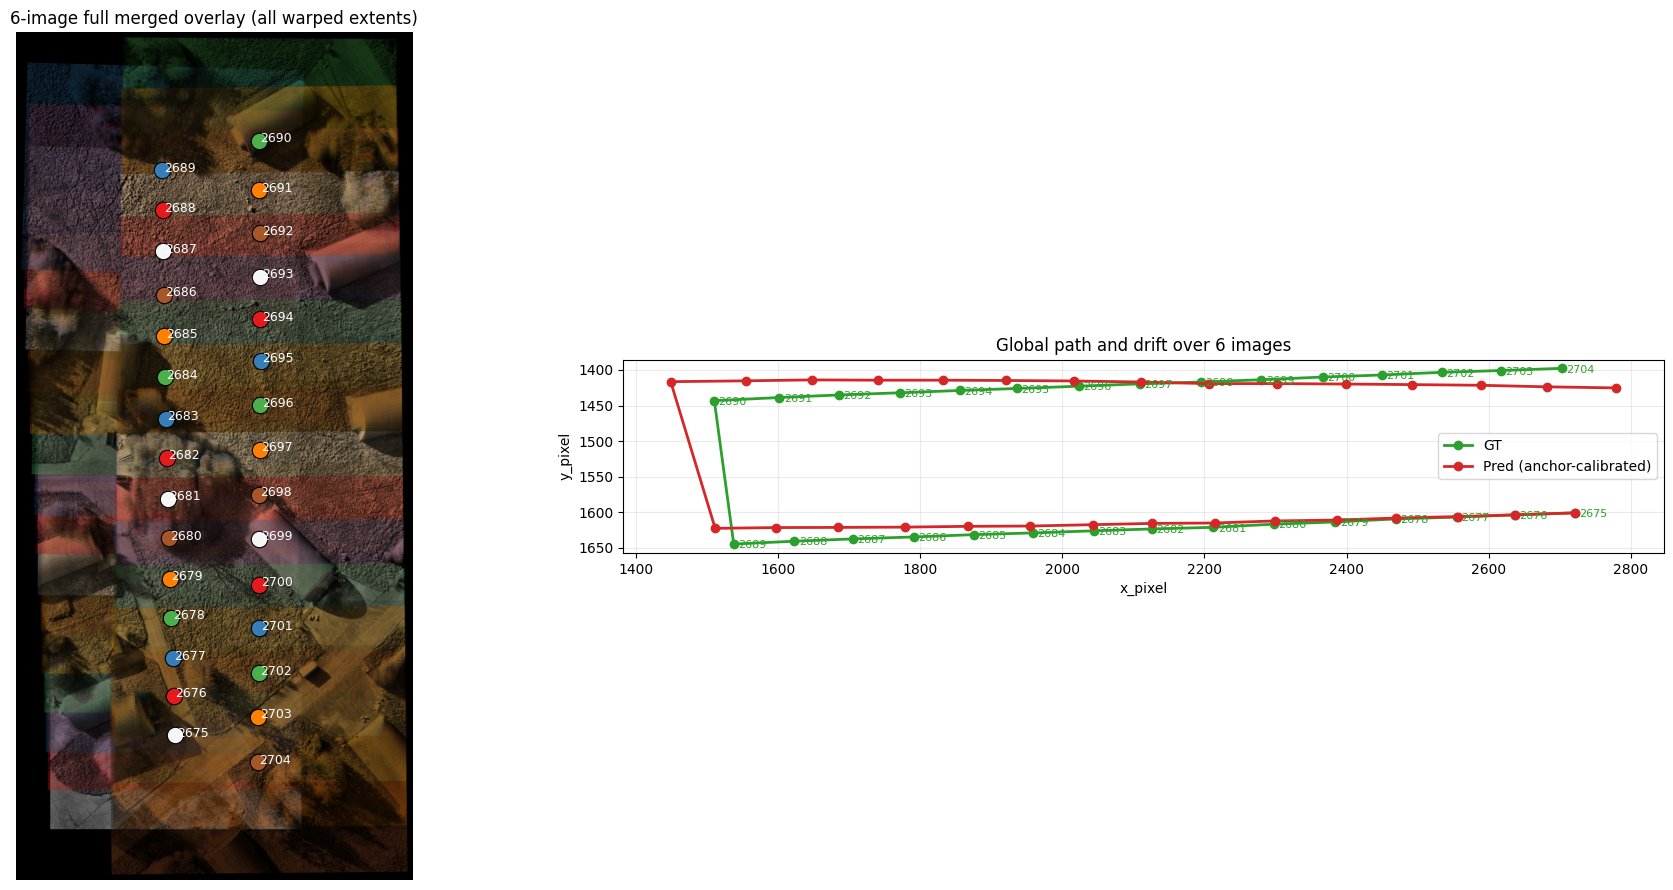

In [42]:
# Combined visualization: all 6 images in one anchor overlay + global trajectory
SEQ_COLORS = [
    (245, 245, 245),
    (228, 26, 28),
    (55, 126, 184),
    (77, 175, 74),
    (255, 127, 0),
    (166, 86, 40),
]
CANVAS_PADDING = 30

# Build a full canvas from transformed corners of all 6 images
all_corners = []
for image_id in seq_ids:
    gray = seq_data[int(image_id)]["gray"]
    h, w = gray.shape[:2]
    corners = np.array(
        [[0.0, 0.0], [w - 1.0, 0.0], [w - 1.0, h - 1.0], [0.0, h - 1.0]],
        dtype=np.float32,
    )
    corners_anchor = transform_points_hom(T_to_anchor[int(image_id)], corners)
    all_corners.append(corners_anchor)

all_corners = np.vstack(all_corners)
min_xy = np.floor(all_corners.min(axis=0) - CANVAS_PADDING).astype(np.int32)
max_xy = np.ceil(all_corners.max(axis=0) + CANVAS_PADDING).astype(np.int32)

canvas_w = int(max_xy[0] - min_xy[0] + 1)
canvas_h = int(max_xy[1] - min_xy[1] + 1)

T_shift = np.array(
    [[1.0, 0.0, -float(min_xy[0])], [0.0, 1.0, -float(min_xy[1])], [0.0, 0.0, 1.0]],
    dtype=np.float64,
)
T_to_canvas = {int(image_id): T_shift @ T_to_anchor[int(image_id)] for image_id in seq_ids}

overlay = np.zeros((canvas_h, canvas_w, 3), dtype=np.float32)

for idx, image_id in enumerate(seq_ids):
    gray = seq_data[int(image_id)]["gray"]
    M = T_to_canvas[int(image_id)][:2, :]
    warped = cv2.warpAffine(gray, M, (canvas_w, canvas_h), flags=cv2.INTER_LINEAR, borderValue=0)

    tint = np.array(SEQ_COLORS[idx % len(SEQ_COLORS)], dtype=np.float32) / 255.0
    layer = (warped.astype(np.float32) / 255.0)[..., None] * tint[None, None, :]
    mask = warped > 0
    alpha = 0.50 if idx == 0 else 0.36
    overlay[mask] = (1.0 - alpha) * overlay[mask] + alpha * layer[mask]

overlay = np.clip(overlay, 0.0, 1.0)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))
ax0, ax1 = axes

ax0.imshow(overlay)
ax0.set_title("6-image full merged overlay (all warped extents)")
ax0.axis("off")

# Draw warped inlier points from each follower image
for step in seq_pair_steps:
    curr_id = int(step["curr_id"])
    res = step["res"]
    color = np.array(SEQ_COLORS[seq_ids.index(curr_id) % len(SEQ_COLORS)], dtype=np.float32) / 255.0

    if res.pts1.shape[0] == 0:
        continue
    inl = res.affine_inliers if res.affine_inliers.shape[0] == res.pts1.shape[0] else np.zeros((res.pts1.shape[0],), dtype=bool)
    pts_curr = res.pts1[inl]
    if pts_curr.shape[0] == 0:
        continue

    if pts_curr.shape[0] > int(SEQ_OVERLAY_POINT_LIMIT):
        pts_curr = pts_curr[: int(SEQ_OVERLAY_POINT_LIMIT)]

    pts_canvas = transform_points_hom(T_to_canvas[curr_id], pts_curr)
    # ax0.scatter(pts_canvas[:, 0], pts_canvas[:, 1], s=4, c=[color], alpha=0.30)

# Draw center point for each image in merged canvas frame
for idx, image_id in enumerate(seq_ids):
    gray = seq_data[int(image_id)]["gray"]
    h, w = gray.shape[:2]
    center = np.array([[w * 0.5, h * 0.5]], dtype=np.float32)
    center_canvas = transform_points_hom(T_to_canvas[int(image_id)], center)[0]
    color = np.array(SEQ_COLORS[idx % len(SEQ_COLORS)], dtype=np.float32) / 255.0
    ax0.scatter(center_canvas[0], center_canvas[1], s=140, c=[color], edgecolors="black", linewidths=0.8)
    ax0.text(center_canvas[0] + 8, center_canvas[1] + 8, str(int(image_id)), color="white", fontsize=9)

# Global coordinate path: GT vs predicted
gt_xy = seq_eval_df[["gt_x", "gt_y"]].to_numpy(dtype=float)
pred_xy = seq_eval_df[["pred_x", "pred_y"]].to_numpy(dtype=float)

ax1.plot(gt_xy[:, 0], gt_xy[:, 1], "-o", color="tab:green", linewidth=2.0, label="GT")
ax1.plot(pred_xy[:, 0], pred_xy[:, 1], "-o", color="tab:red", linewidth=2.0, label="Pred (anchor-calibrated)")

for _, row in seq_eval_df.iterrows():
    image_id = int(row["id"])
    ax1.text(float(row["gt_x"]) + 6, float(row["gt_y"]) + 6, str(image_id), color="tab:green", fontsize=8)

ax1.set_title("Global path and drift over 6 images")
ax1.set_xlabel("x_pixel")
ax1.set_ylabel("y_pixel")
ax1.invert_yaxis()
ax1.set_aspect("equal", adjustable="box")
ax1.grid(alpha=0.25)
ax1.legend(loc="best")

plt.tight_layout()
plt.show()

